# Submit Deforestation

This notebook creates the deforestation submission

In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime, timedelta
from tqdm import tqdm
import cv2
import glob

from multiearth_challenge.datasets import segmentation_dataset as sd
from multiearth_challenge.datasets import base_datasets as bd
from multiearth_challenge import tiff_file_tools as tft
from dateutil.relativedelta import relativedelta

from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_auc_score

%matplotlib inline

In [2]:
DATA_PATH = 'data/multiearth2023-dataset-final/'
DP_PATH = './dp'

In [3]:
deforest_targets = pd.read_csv('deforest_targets.csv')
deforest_targets.lon = deforest_targets.lon.round(2)
deforest_targets.lat = deforest_targets.lat.round(2)
deforest_targets

,date,target_path,lat,lon
0,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.07,-54.80
1,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.11,-54.80
2,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-3.95,-54.80
3,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.23,-54.82
4,2021-05-01,data/multiearth2023-dataset-final/forest_targe...,-4.25,-54.88
...,...,...,...,...
995,2021-08-01,data/multiearth2023-dataset-final/forest_targe...,-3.99,-54.88
996,2021-08-01,data/multiearth2023-dataset-final/forest_targe...,-4.25,-54.82
997,2021-08-01,data/multiearth2023-dataset-final/forest_targe...,-4.01,-54.86
998,2021-08-01,data/multiearth2023-dataset-final/forest_targe...,-3.95,-54.80


In [16]:
cfg_name = 'forest_ws2_30d_r8_all'
fold = 0
epoch = 9
exp_dir = f"output/models/{cfg_name}/"
P = np.load(f"{exp_dir}test_data_f{fold}_e{epoch}.npy")

In [5]:
P.shape, P.mean()

((1000, 1, 256, 256), 0.46825236)

In [6]:
# For simple single model submission select one experiment
cfgs = [
    'forest_ws2_60d_expert',
    'forest_ws2_60d_r8_all',
    'forest_ws2_30d_r8_all',
    'forest_ws2_60d_r10',
    'forest_ws2_72d_r16',
    'forest_ws2_60d_r8_fix_bands',
    'forest_wos2_60d_r8_all',
    'forest_ws2_final_v2',
]
epochs = [8, 9]
folds = [-1]

In [7]:
ENS_PRED = np.zeros_like(P)
n_preds = 0
for cfg_name in cfgs:
    exp_dir = f"output/models/{cfg_name}/"
    for epoch in epochs:
        for fold in folds:
            test_pred_path = f"{exp_dir}test_data_f{fold}_e{epoch}.npy"
            if os.path.exists(test_pred_path):
                P = np.load(test_pred_path)
                print(cfg_name, epoch, fold)
                n_preds += 1
                ENS_PRED += P
print(n_preds)
ENS_PRED = ENS_PRED / n_preds
ENS_PRED.shape, ENS_PRED.mean()

forest_ws2_60d_expert 8 -1
forest_ws2_60d_expert 9 -1
forest_ws2_60d_r8_all 8 -1
forest_ws2_60d_r8_all 9 -1
forest_ws2_30d_r8_all 8 -1
forest_ws2_30d_r8_all 9 -1
forest_ws2_60d_r10 8 -1
forest_ws2_60d_r10 9 -1
forest_ws2_72d_r16 8 -1
forest_ws2_72d_r16 9 -1
forest_ws2_60d_r8_fix_bands 8 -1
forest_ws2_60d_r8_fix_bands 9 -1
forest_wos2_60d_r8_all 8 -1
forest_wos2_60d_r8_all 9 -1
forest_ws2_final_v2 8 -1
forest_ws2_final_v2 9 -1
16


((1000, 1, 256, 256), 0.4628715)

In [8]:
!rm -rf estimation

In [9]:
# binarization threshold
thr = 0.45
submission_name = "estimation"
subm_dir = f'subm/{submission_name}'
os.makedirs(subm_dir, exist_ok=True)

In [10]:
n = 0
for i, (target_date, lat, lon) in enumerate(deforest_targets[['date', 'lat', 'lon']].values):
    img = ENS_PRED[i, 0, :, :]
    binary_pred = (1 * (img > thr)).astype(np.int8)
    f = f"deforestation_{lon:.2f}_{lat:.2f}_{target_date.replace('-', '_')}.tiff"
    target_path = f"{subm_dir}/{f}"
    #     img.shape, img.mean(), f, binary_pred.mean()
    
    _ = cv2.imwrite(target_path, binary_pred)

In [11]:
len(os.listdir(subm_dir))
subm_dir

1000

'subm/estimation'

### Check example predictions and binary mask

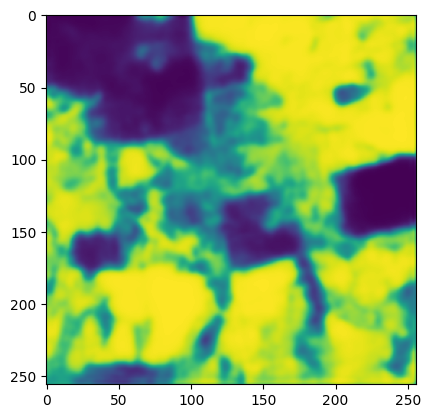

In [14]:
_ = plt.imshow(img)

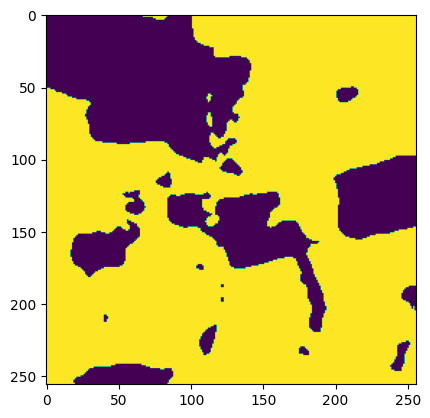

In [15]:
_ = plt.imshow(binary_pred)